# Experiment 1: Doing 1-D regression and see whether NP can learn the underlying shared mechanism between tastks (same kernel structure in GP)

In [1]:
import numpy as np
import GPy
import matplotlib.pylab as plt

from NP_algorithm import *
from NP_multitask_learning import *

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

%matplotlib inline
plt.style.use('seaborn')

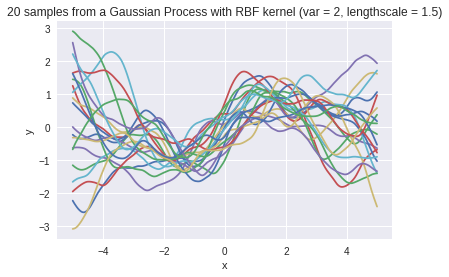

In [2]:
# Simulate a GP
x = np.random.uniform(-3, 3, (20, 1))
y = np.sin(x) + np.random.randn(20, 1) * 0.05

# Setup kernel
kernel = GPy.kern.Matern52(input_dim=1, variance=2, lengthscale=1.5)

# Setup model but not train it
m = GPy.models.GPRegression(x,y,kernel)

# Plot
xx = np.linspace(-5, 5, 1000).reshape(-1,1)
posterior_y = np.matrix(m.posterior_samples_f(X=xx, size=20))

for i in range(20):
    plt.plot(xx, posterior_y[:, i])
    plt.title("20 samples from a Gaussian Process with RBF kernel (var = 2, lengthscale = 1.5)")
    plt.xlabel("x")
    plt.ylabel("y")

### Now create 20 task sets each with 5 instances each

In [3]:
# Randomly pick 10 labels for each set
label_mat = np.matrix(np.random.choice(1000,size=(5,20)))
train_sets = []

for col in range(20):
    train_sets.append([xx.reshape(1,-1)[0][label_mat[:,col]], np.array(posterior_y[label_mat[:,col], col])])

In [4]:
x_train = dict()
y_train = dict()
x_test = dict()
y_test = dict()

for i in range(20):
    x_train["task " + str(i)] = train_sets[i][0][:3].astype(np.float32)
    y_train["task " + str(i)] = train_sets[i][1][:3].astype(np.float32)
    x_test["task " + str(i)] = train_sets[i][0][3:].astype(np.float32)
    y_test["task " + str(i)] = train_sets[i][1][3:].astype(np.float32)

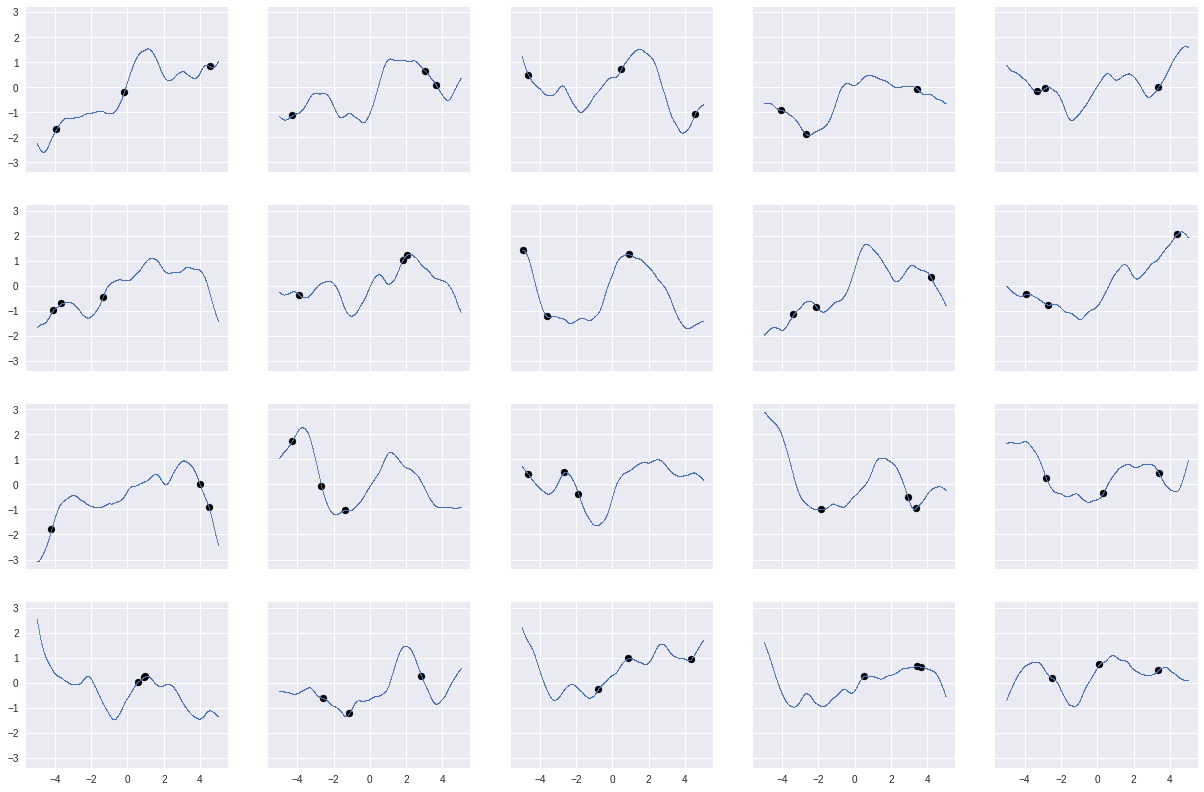

In [5]:
fig, axes = plt.subplots(4, 5, figsize = (21, 14), sharex = True, sharey=True)

for i in range(20):
    axes[int(i/5), i%5].scatter(train_sets[i][0][:3], np.array(train_sets[i][1])[:3],c="black")
    # axes[int(i/5), i%5].scatter(train_sets[i][0][3:], np.array(train_sets[i][1])[3:],c="r")
    axes[int(i/5), i%5].scatter(xx, np.array(posterior_y[:,i]), s=0.5)


# Fit a NP to those our training set

* Idea: For each task, we will generate its own latent representation. context + target is associate with the same task. The only "meta" thing in this case is the network structures.
* Variables:
    * x_train - dictionary with key "task {i}" that contains an array of the x co-ordinate of a task　(7 points)
    * y_train - dictionary with key "task {i}" that contains an array of the y co-ordinate of a task (7 points)
    * x_test
    * y_test

In [38]:
# Train the NP to obtain the coders and the latent representation of the tasks
r_encoder, z_encoder, decoder, z_param_dict = NP_train_swap(x_train, y_train, [3,3,1,1], 50, 5000)

In [49]:
x_g = torch.from_numpy(np.arange(-5,5, 0.1).reshape(-1,1).astype(np.float32))
plot_task = dict()

for task in range(20):
    plot_task["task "+str(task)] = decoder(
        x_g, sample_z(z_param_dict["task "+str(task)][0][0], z_param_dict["task "+str(task)][0][1], 50, 3))[0].data.numpy()

In [50]:
gp_kernel = RBF(length_scale=1) + WhiteKernel(1e-3)

xx2 = x_g.data.numpy()
y_pred_mean = dict()
y_pred_std = dict()


# set up 20 Gaussian processes and fit 7 points to each of them and see how the results differ.
task_ls = ['task ' + str(i) for i in range(20)]

for task in task_ls:
    gpr = GaussianProcessRegressor(kernel=gp_kernel)
    gpr.fit(x_train[task], y_train[task])
    y_mean, y_std = gpr.predict(xx2, return_std = True)
    y_pred_mean[task] = y_mean
    y_pred_std[task] = y_std
    

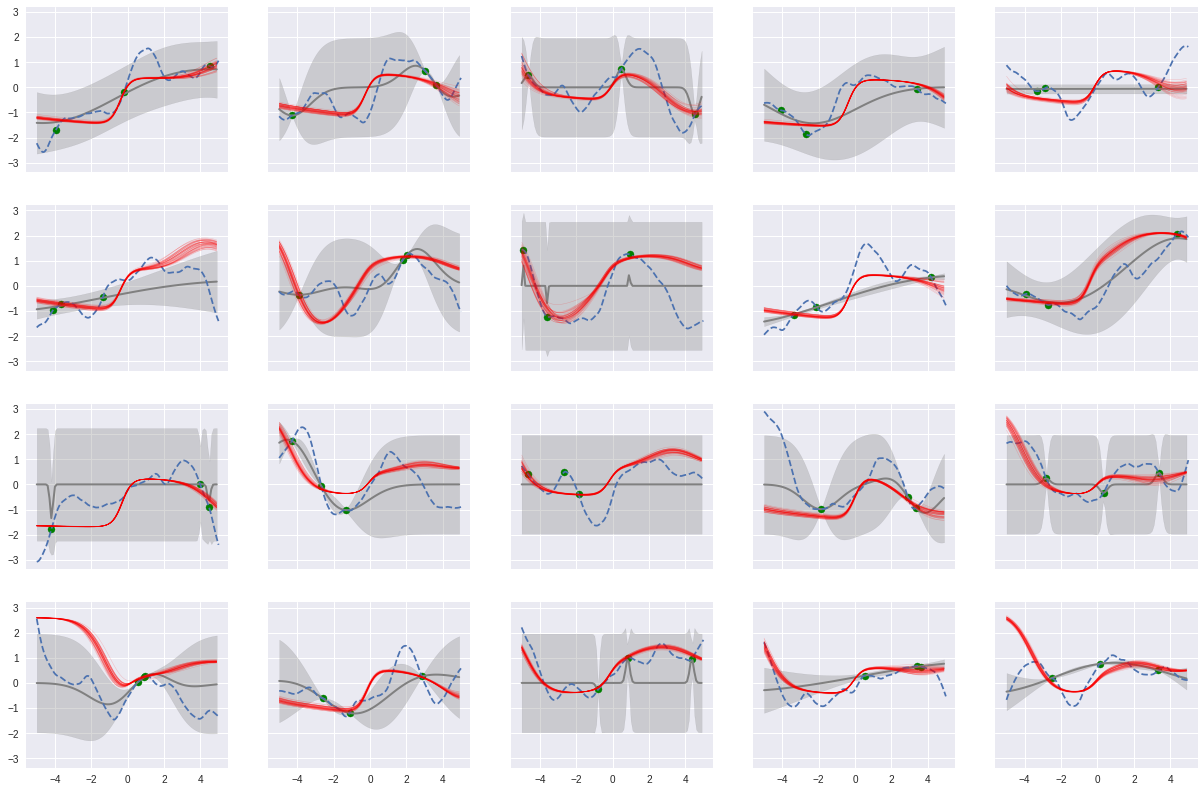

In [51]:
fig, axes = plt.subplots(4, 5, figsize = (21, 14), sharex = True, sharey=True)

for i in range(20):
    axes[int(i/5), i%5].plot(xx2, y_pred_mean['task '+str(i)], lw=2, color="grey")
    upper_limit = (y_pred_mean['task '+str(i)].reshape(1,-1) + 1.96 * y_pred_std['task '+str(i)].reshape(1,-1)).reshape(1,-1)
    lower_limit = (y_pred_mean['task '+str(i)].reshape(1,-1) - 1.96 * y_pred_std['task '+str(i)].reshape(1,-1)).reshape(1,-1)
    axes[int(i/5), i%5].fill_between(xx2[:,0], upper_limit.reshape(-1,1)[:,0], lower_limit.reshape(-1,1)[:,0],color="grey",alpha=0.3)
    axes[int(i/5), i%5].plot(xx, np.array(posterior_y[:,i]), "--")
    axes[int(i/5), i%5].plot(x_g.data.numpy(), plot_task["task "+str(i)], alpha=0.2, color="red", linewidth=0.5)
    axes[int(i/5), i%5].scatter(train_sets[i][0][:3], np.array(train_sets[i][1])[:3],c="green",s=50)        
    # axes[int(i/5), i%5].scatter(train_sets[i][0][3:], np.array(train_sets[i][1])[3:],c="r")        

# fig.suptitle("Results of each GP", size=30)

# Look into task 4

In [56]:
def plot_specific_task(i):
    plt.plot(xx2, y_pred_mean['task '+str(i)], lw=2, color="grey")
    upper_limit = (y_pred_mean['task '+str(i)].reshape(1,-1) + 1.96 * y_pred_std['task '+str(i)].reshape(1,-1)).reshape(1,-1)
    lower_limit = (y_pred_mean['task '+str(i)].reshape(1,-1) - 1.96 * y_pred_std['task '+str(i)].reshape(1,-1)).reshape(1,-1)
    plt.fill_between(xx2[:,0], upper_limit.reshape(-1,1)[:,0], lower_limit.reshape(-1,1)[:,0],color="grey",alpha=0.3)
    plt.plot(xx, np.array(posterior_y[:,i]), "--")
    plt.plot(x_g.data.numpy(), plot_task["task "+str(i)], alpha=0.2, color="red", linewidth=0.5)
    plt.scatter(train_sets[i][0][:3], np.array(train_sets[i][1])[:3],c="green",s=50)        
    plt.show()


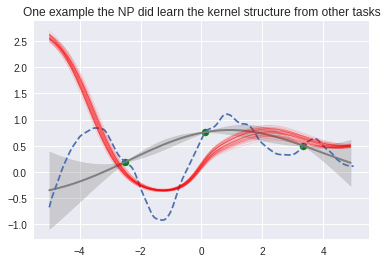

In [57]:
plt.title("One example the NP did learn the kernel structure from other tasks")
plot_specific_task(19)


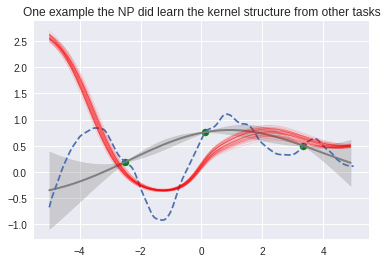

In [58]:
plt.title("One example the NP did learn the kernel structure from other tasks")
plot_specific_task(19)


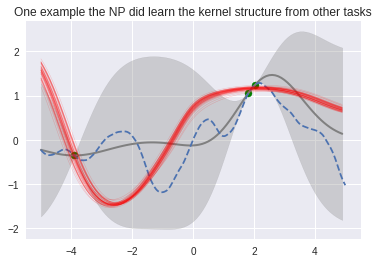

In [59]:
plt.title("One example the NP did learn the kernel structure from other tasks")
plot_specific_task(6)


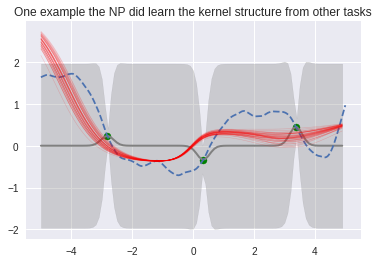

In [60]:
plt.title("One example the NP did learn the kernel structure from other tasks")
plot_specific_task(14)


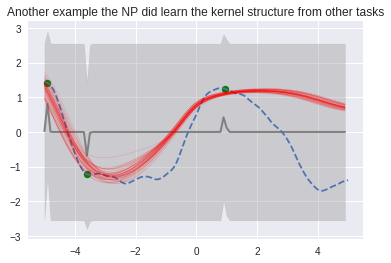

In [62]:
plt.title("Another example the NP did learn the kernel structure from other tasks")
plot_specific_task(7)
